In [17]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


%matplotlib inline

In [18]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [50]:
def ROC_sk(filename, amp, site, ax, n_steps=1000):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    
    #print(data[trials_mask])
    
    y_score = mn_dnd_chng[trials_mask, site]
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    
    #present = mn_dnd_chng[present_mask,site]
    #absent = mn_dnd_chng[absent_mask,site]

    #min_crit = np.min(absent)
    #max_crit = np.max(present)
    
    #tp = []
    #fp = []

    #for crit in np.linspace(min_crit, max_crit, n_steps):
    #    tp.append(np.sum(present>crit)/present.shape[0])
    #    fp.append(np.sum(absent>crit)/absent.shape[0])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    AUC = auc(fpr, tpr, reorder=False)
    
    n_steps = thresholds.shape[0]
    
    if AUC > 0.5:
        ax.plot(fpr, tpr)
        ax.fill_between(fpr, np.zeros(n_steps), tpr, facecolor="#D47F00", alpha=0.8)
    else:
        ax.plot(tpr, fpr)
        ax.fill_between(tpr, np.zeros(n_steps), fpr, facecolor="#D47F00", alpha=0.8)
        
    ax.plot(np.linspace(0,1,n_steps), np.linspace(0,1,n_steps), color='k', linestyle='--')
    #ax.fill_between(fpr, np.zeros(n_steps), tpr, facecolor="#D47F00", alpha=0.8)
    ax.set_aspect('equal')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    return AUC

In [20]:
def ROC_psycho(filename, amp, site, ax, n_steps=1000):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']
    
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

    baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)

    mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    hit_mask = meta[:, 2]==1
    
    #print(data[trials_mask])
    
    y_score = mn_dnd_chng[trials_mask, site]
    
    end_mask = hit_mask[trials_mask]
    y_true = (end_mask-0.5)*2
    
    #present = mn_dnd_chng[present_mask,site]
    #absent = mn_dnd_chng[absent_mask,site]

    #min_crit = np.min(absent)
    #max_crit = np.max(present)
    
    #tp = []
    #fp = []

    #for crit in np.linspace(min_crit, max_crit, n_steps):
    #    tp.append(np.sum(present>crit)/present.shape[0])
    #    fp.append(np.sum(absent>crit)/absent.shape[0])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    AUC = auc(fpr, tpr, reorder=False)
    
    n_steps = thresholds.shape[0]
        
    ax.plot(fpr, tpr)
    ax.plot(np.linspace(0,1,n_steps), np.linspace(0,1,n_steps), color='k', linestyle='--')
    ax.fill_between(fpr, np.zeros(n_steps), tpr, facecolor="#B09473", alpha=1)
    ax.set_aspect('equal')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    return AUC

In [25]:
def get_DIs(filename, amp, permute=False):
    '''
    Computes DIs for all recordings sites of file 'filename' and amplitude 'amp'.
    '''
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']
    
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

    baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], np.sum(motion_mask), 1)

    mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    if permute==True:
        y_true = np.random.permutation(y_true)
    
    DIs = []
    for site in range(np.sum(motion_mask)):
        y_score = mn_dnd_chng[trials_mask, site]
    
        DIs.append((roc_auc_score(y_true, y_score)-0.5)*2)
    return DIs

In [26]:
def get_DIs_psycho(filename, amp, permute=False):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']
    
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[:]
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

    baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)

    mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    hit_mask = meta[:, 2]==1
    
    #print(data[trials_mask])
    
    end_mask = hit_mask[trials_mask]
    y_true = (end_mask-0.5)*2
    
    #compute balance in y_true
    balance = np.sum(end_mask)/end_mask.shape[0]
    n_y = end_mask.shape[0]
    
    if permute==True:
        y_true = np.random.permutation(y_true)
    
    DIs = []
    for site in range(np.sum(motion_mask)):
        y_score = mn_dnd_chng[trials_mask, site]
    
        DIs.append((roc_auc_score(y_true, y_score)-0.5)*2)
    return DIs, balance, n_y

In [27]:
#include absent trials?

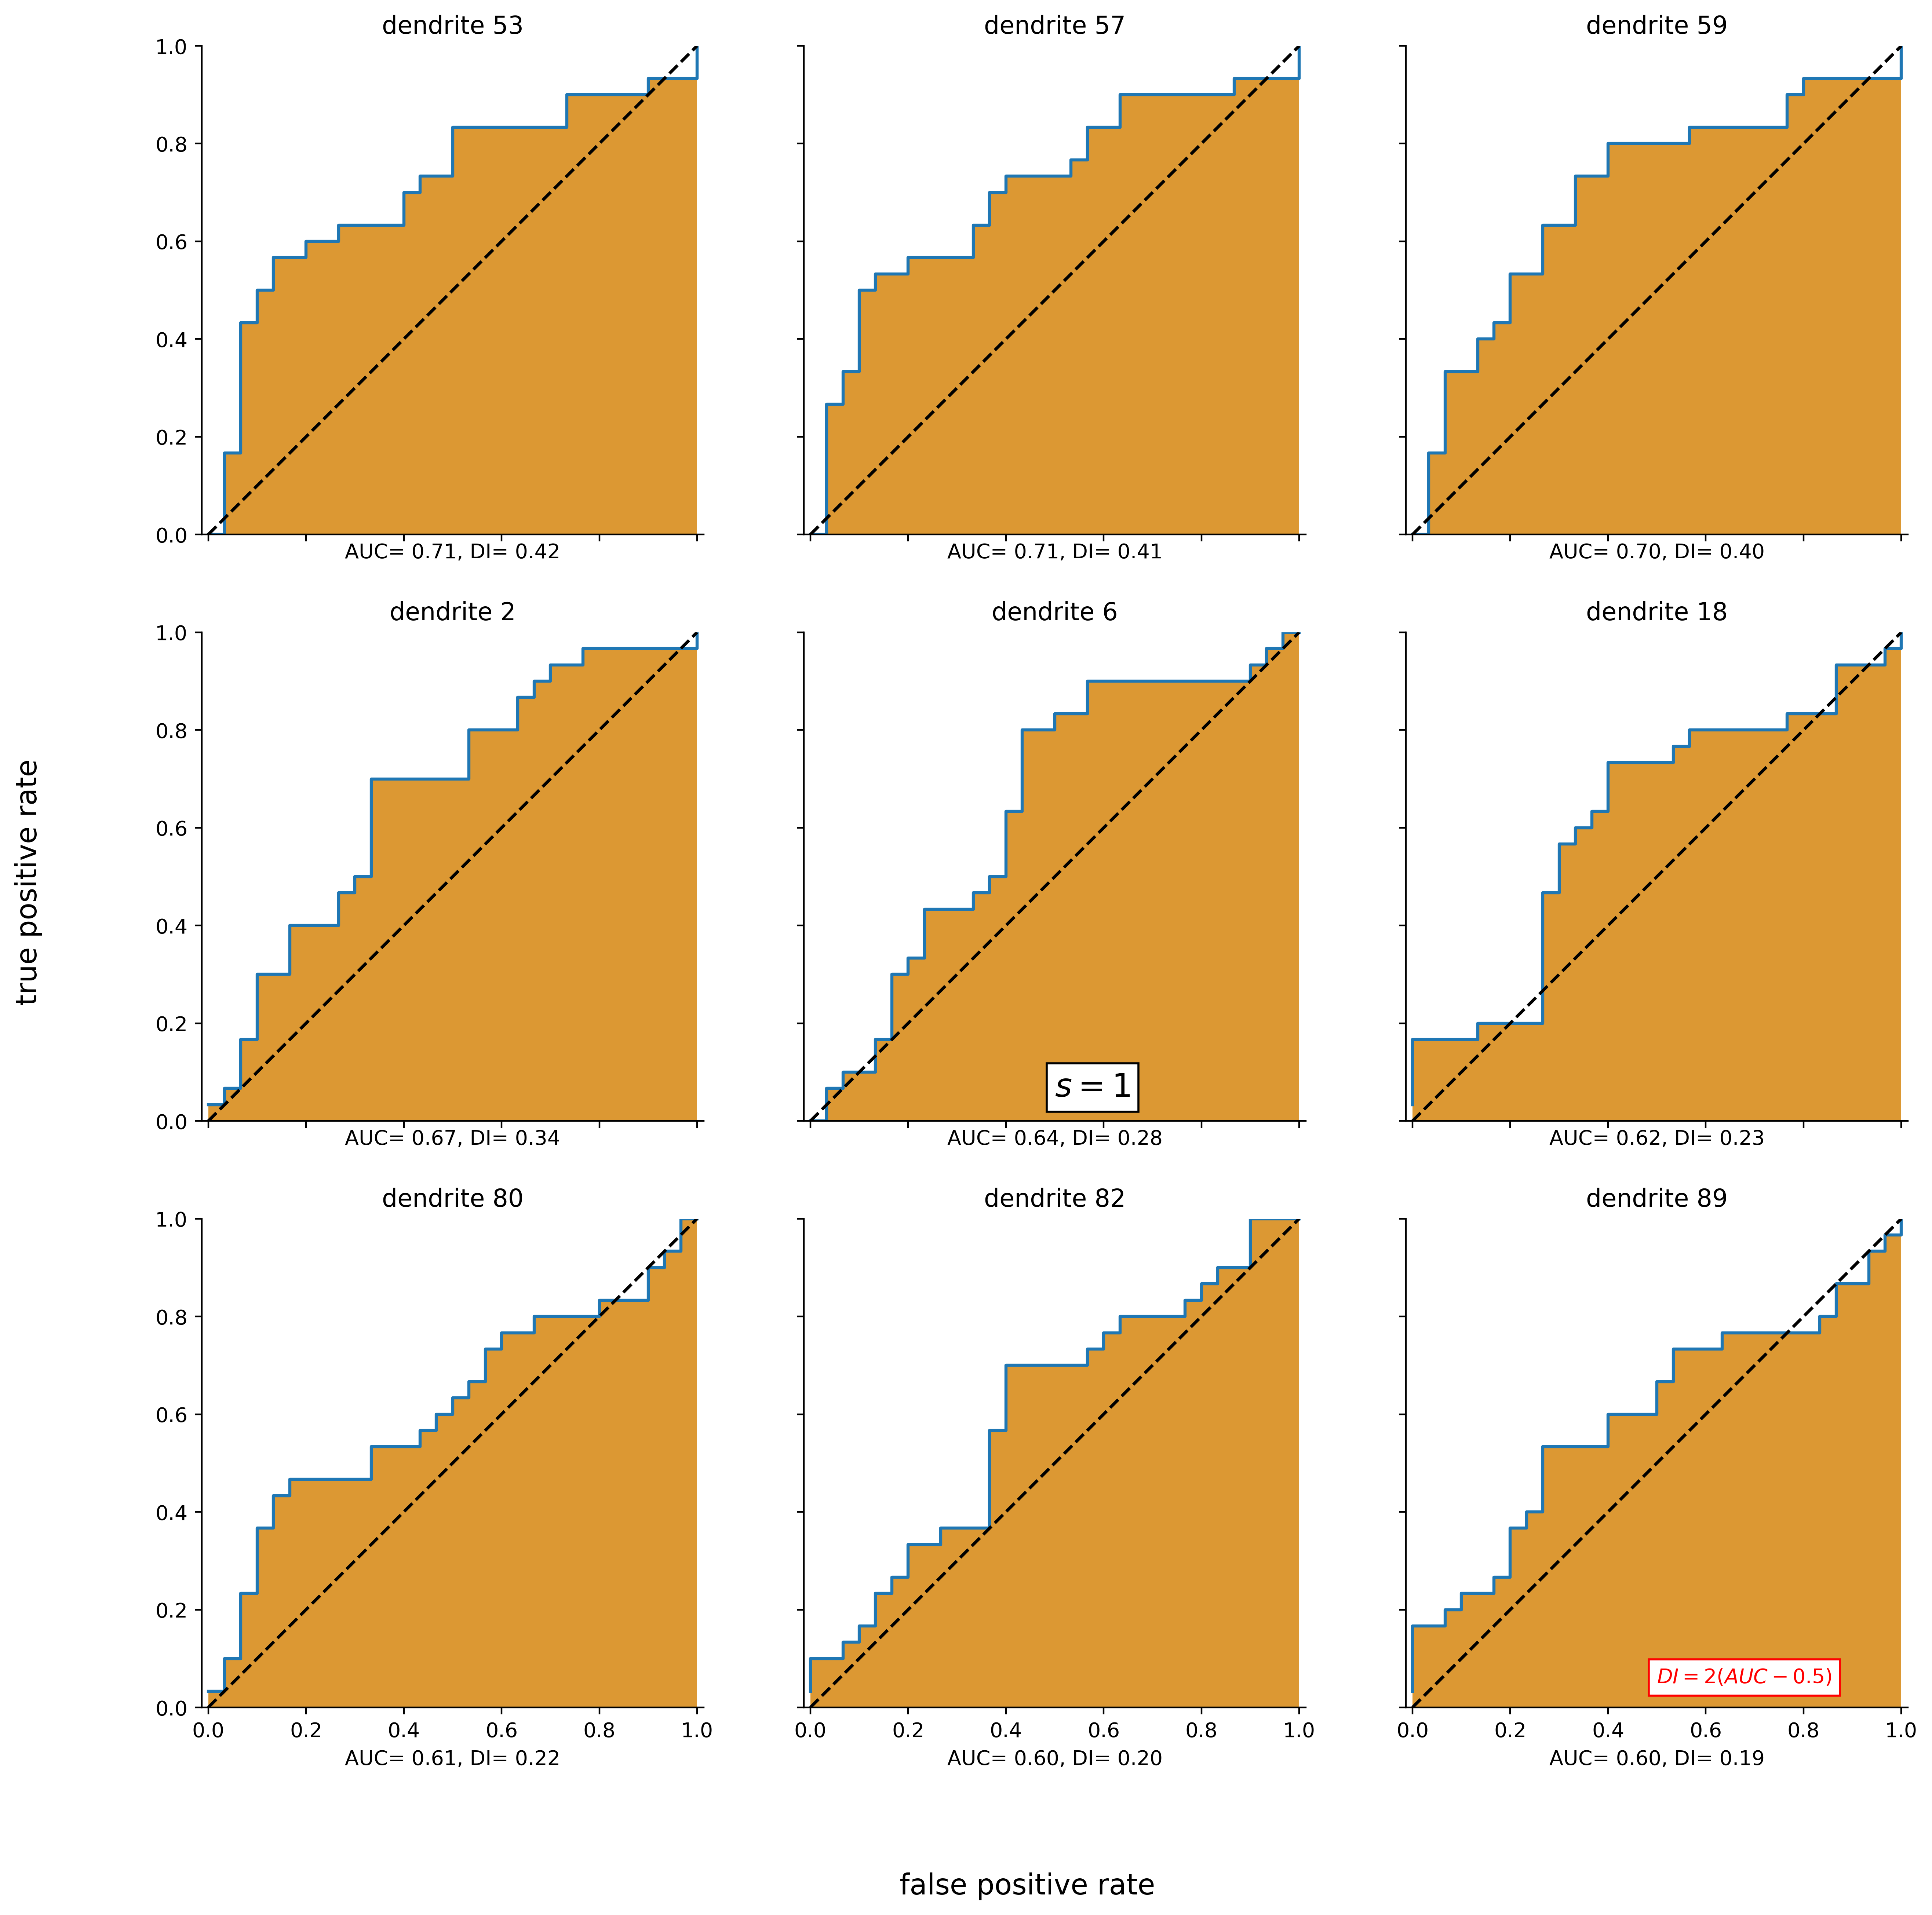

In [64]:
filename = filelist[2]
stim_amp = 1

g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])

sort = 'max'

DIs = np.array(get_DIs(filename, stim_amp))

if sort == 'max':
    inds = np.argsort(DIs)[::-1][:9]
if sort == 'min':
    inds = np.argsort(DIs)[:9]
if sort == 'rand':
    inds = np.random.choice(n_dendrites, 9, replace=False)

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for k, i in enumerate(inds):
    c=0
    for j in range(len(motion_mask)):
        if c == i:
                break
        if motion_mask[j] == True:
            c += 1
    AUC = ROC_sk(filename, stim_amp, j, axes[k])
    axes[k].set_title('dendrite {}'.format(j))
    axes[k].set_xlabel('AUC={0: .2f}, DI={1: .2f}'.format(AUC, (AUC-0.5)*2))
    
axes[k].text(0.5, 0.05, '$DI = 2(AUC-0.5)$', color='red', 
        bbox=dict(facecolor='white', edgecolor='red'))

axes[4].text(0.5, 0.05, '$s = 1$', color='black', 
        bbox=dict(facecolor='white', edgecolor='black'), fontsize=16)

if sort == 'max':
    fig.text(0.5, 0.04, 'false positive rate', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'true positive rate', va='center', rotation='vertical', fontsize=14)
if sort == 'min':
    fig.text(0.5, 0.04, 'true positive rate', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'false positive rate', va='center', rotation='vertical', fontsize=14)
    
fig.savefig('roc_{}.png'.format(sort))

for stimAmp =  0.33: min DI:  -0.47 , max DI:  0.33
for stimAmp =  0.67: min DI:  -0.35 , max DI:  0.27
for stimAmp =  1.00: min DI:  -0.40 , max DI:  0.42
for stimAmp =  1.33: min DI:  -0.56 , max DI:  0.59
for stimAmp =  1.67: min DI:  -0.56 , max DI:  0.49
for stimAmp =  2.00: min DI:  -0.46 , max DI:  0.55


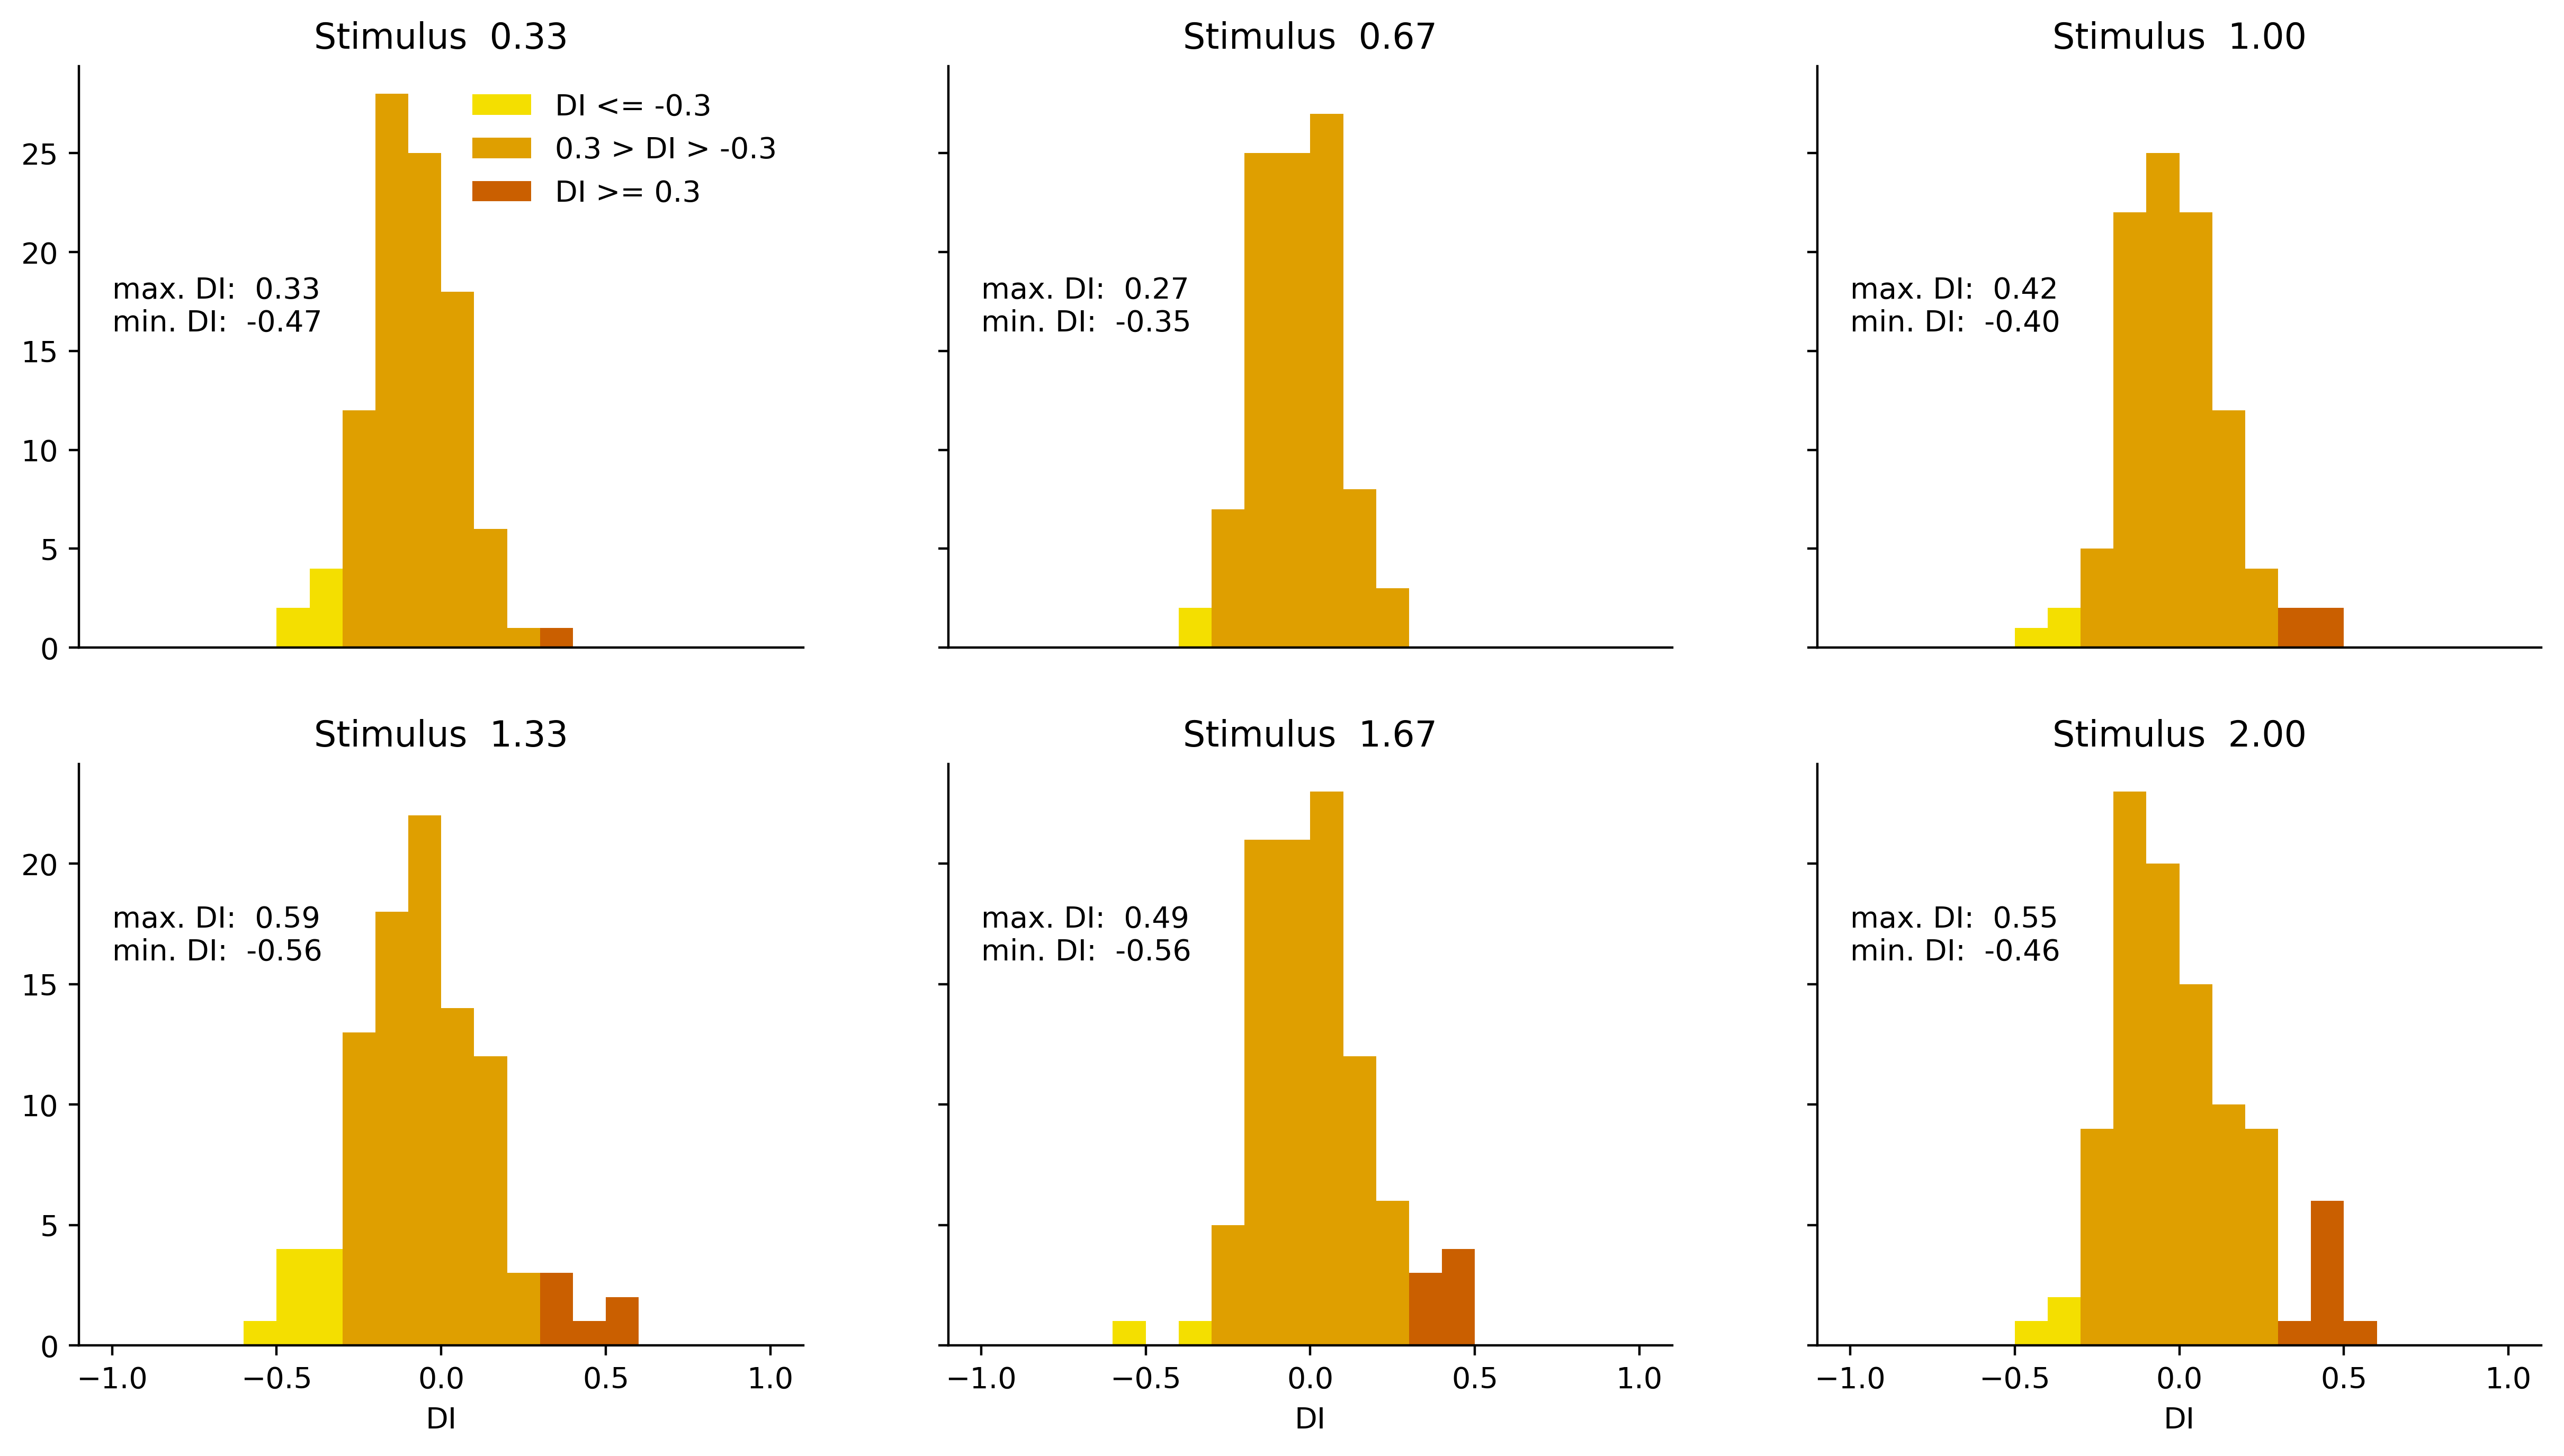

In [80]:
stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]        #exclude zero

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for k, amp in enumerate(stims):
    DIs = np.array(get_DIs(filename, amp))
    print("for stimAmp = {0: .2f}: min DI: ".format(amp) ,"{0: .2f}".format(np.min(DIs)), ", max DI:", "{0: .2f}".format(np.max(DIs)))
    
    lo_mask = DIs <= -0.3
    mid_mask = np.logical_and(DIs >-0.3, DIs <0.3)
    hi_mask = DIs > 0.3

    axes[k].hist(DIs[lo_mask], bins=20, range=(-1,1), label='DI <= -0.3', color='#F4DF00')
    axes[k].hist(DIs[mid_mask], bins=20, range=(-1,1), label='0.3 > DI > -0.3', color='#DF9F00')
    axes[k].hist(DIs[hi_mask], bins=20, range=(-1,1), label='DI >= 0.3', color='#CA5F00')
    
    axes[k].text(-1,16,s='max. DI: {0: .2f}\nmin. DI:  {1: .2f}'.format(np.max(DIs), np.min(DIs)), color='black')
    
    axes[k].set_title('Stimulus {0: .2f}'.format(amp))
    
    axes[k].spines['top'].set_visible(False)
    axes[k].spines['right'].set_visible(False)
    axes[k].get_xaxis().tick_bottom()
    axes[k].get_yaxis().tick_left()
    if k == 0:
        axes[k].legend(frameon=False)
        
    if k in [0,1,2]:
        axes[k].xaxis.set_ticks_position('none')
    if k in [3,4,5]:
        axes[k].set_xlabel('DI')
fig.savefig('DI_hist.png')

for stimAmp =  0.33: min DI:  -0.93 , max DI:  0.97
for stimAmp =  0.67: min DI:  -0.91 , max DI:  0.62
for stimAmp =  1.00: min DI:  -0.79 , max DI:  0.61
for stimAmp =  1.33: min DI:  -0.75 , max DI:  0.60
for stimAmp =  1.67: min DI:  -0.76 , max DI:  0.52
for stimAmp =  2.00: min DI:  -0.75 , max DI:  0.59


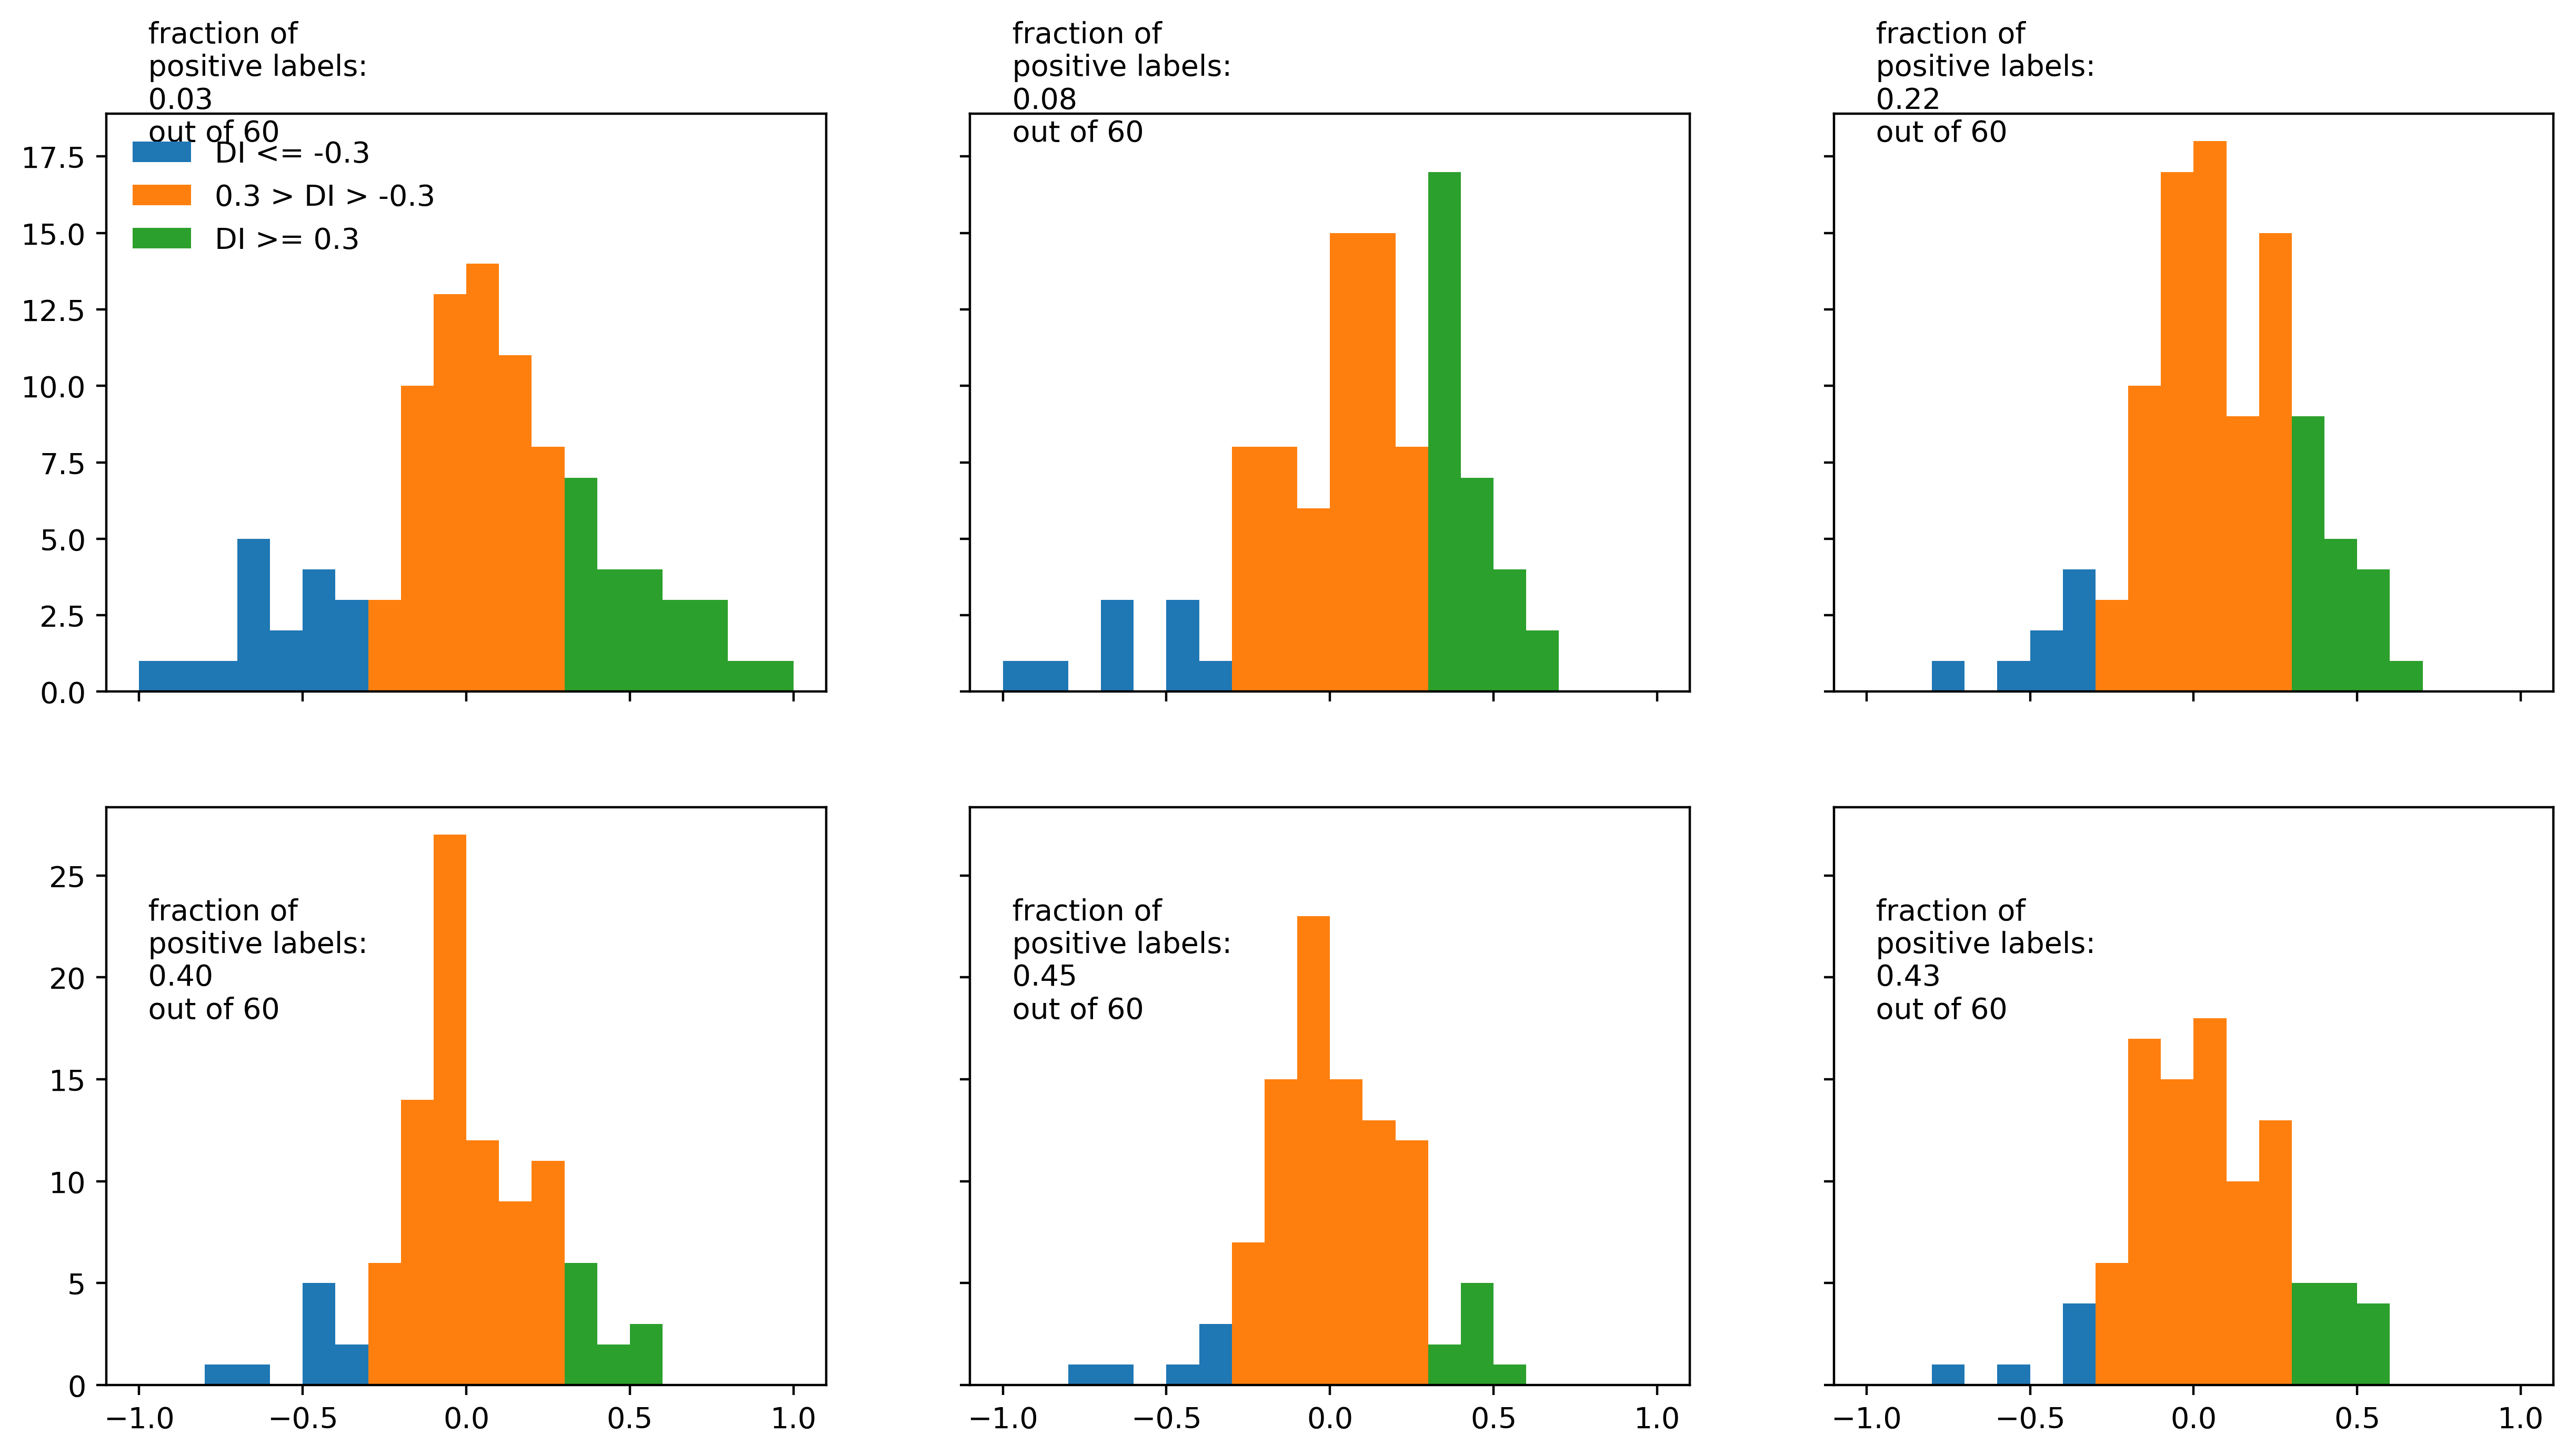

In [14]:
stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]        #exclude zero

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for k, amp in enumerate(stims):
    dis, bal, n_y = get_DIs_psycho(filename, amp, permute=False)
    DIs = np.array(dis)
    print("for stimAmp = {0: .2f}: min DI: ".format(amp) ,"{0: .2f}".format(np.min(DIs)), ", max DI:", "{0: .2f}".format(np.max(DIs)))
    
    lo_mask = DIs <= -0.3
    mid_mask = np.logical_and(DIs >-0.3, DIs <0.3)
    hi_mask = DIs > 0.3

    axes[k].hist(DIs[lo_mask], bins=20, range=(-1,1), label='DI <= -0.3')
    axes[k].hist(DIs[mid_mask], bins=20, range=(-1,1), label='0.3 > DI > -0.3')
    axes[k].hist(DIs[hi_mask], bins=20, range=(-1,1), label='DI >= 0.3')
    axes[k].text(-1,18,' fraction of \n positive labels:\n{0: .2f}\n out of {1}'.format(bal, n_y))
    if k == 0:
        axes[k].legend(frameon=False)

for stimAmp =  0.33: min DI:  -0.47 , max DI:  0.33
for stimAmp =  0.67: min DI:  -0.35 , max DI:  0.27
for stimAmp =  1.00: min DI:  -0.40 , max DI:  0.42
for stimAmp =  1.33: min DI:  -0.56 , max DI:  0.59
for stimAmp =  1.67: min DI:  -0.56 , max DI:  0.49
for stimAmp =  2.00: min DI:  -0.46 , max DI:  0.55


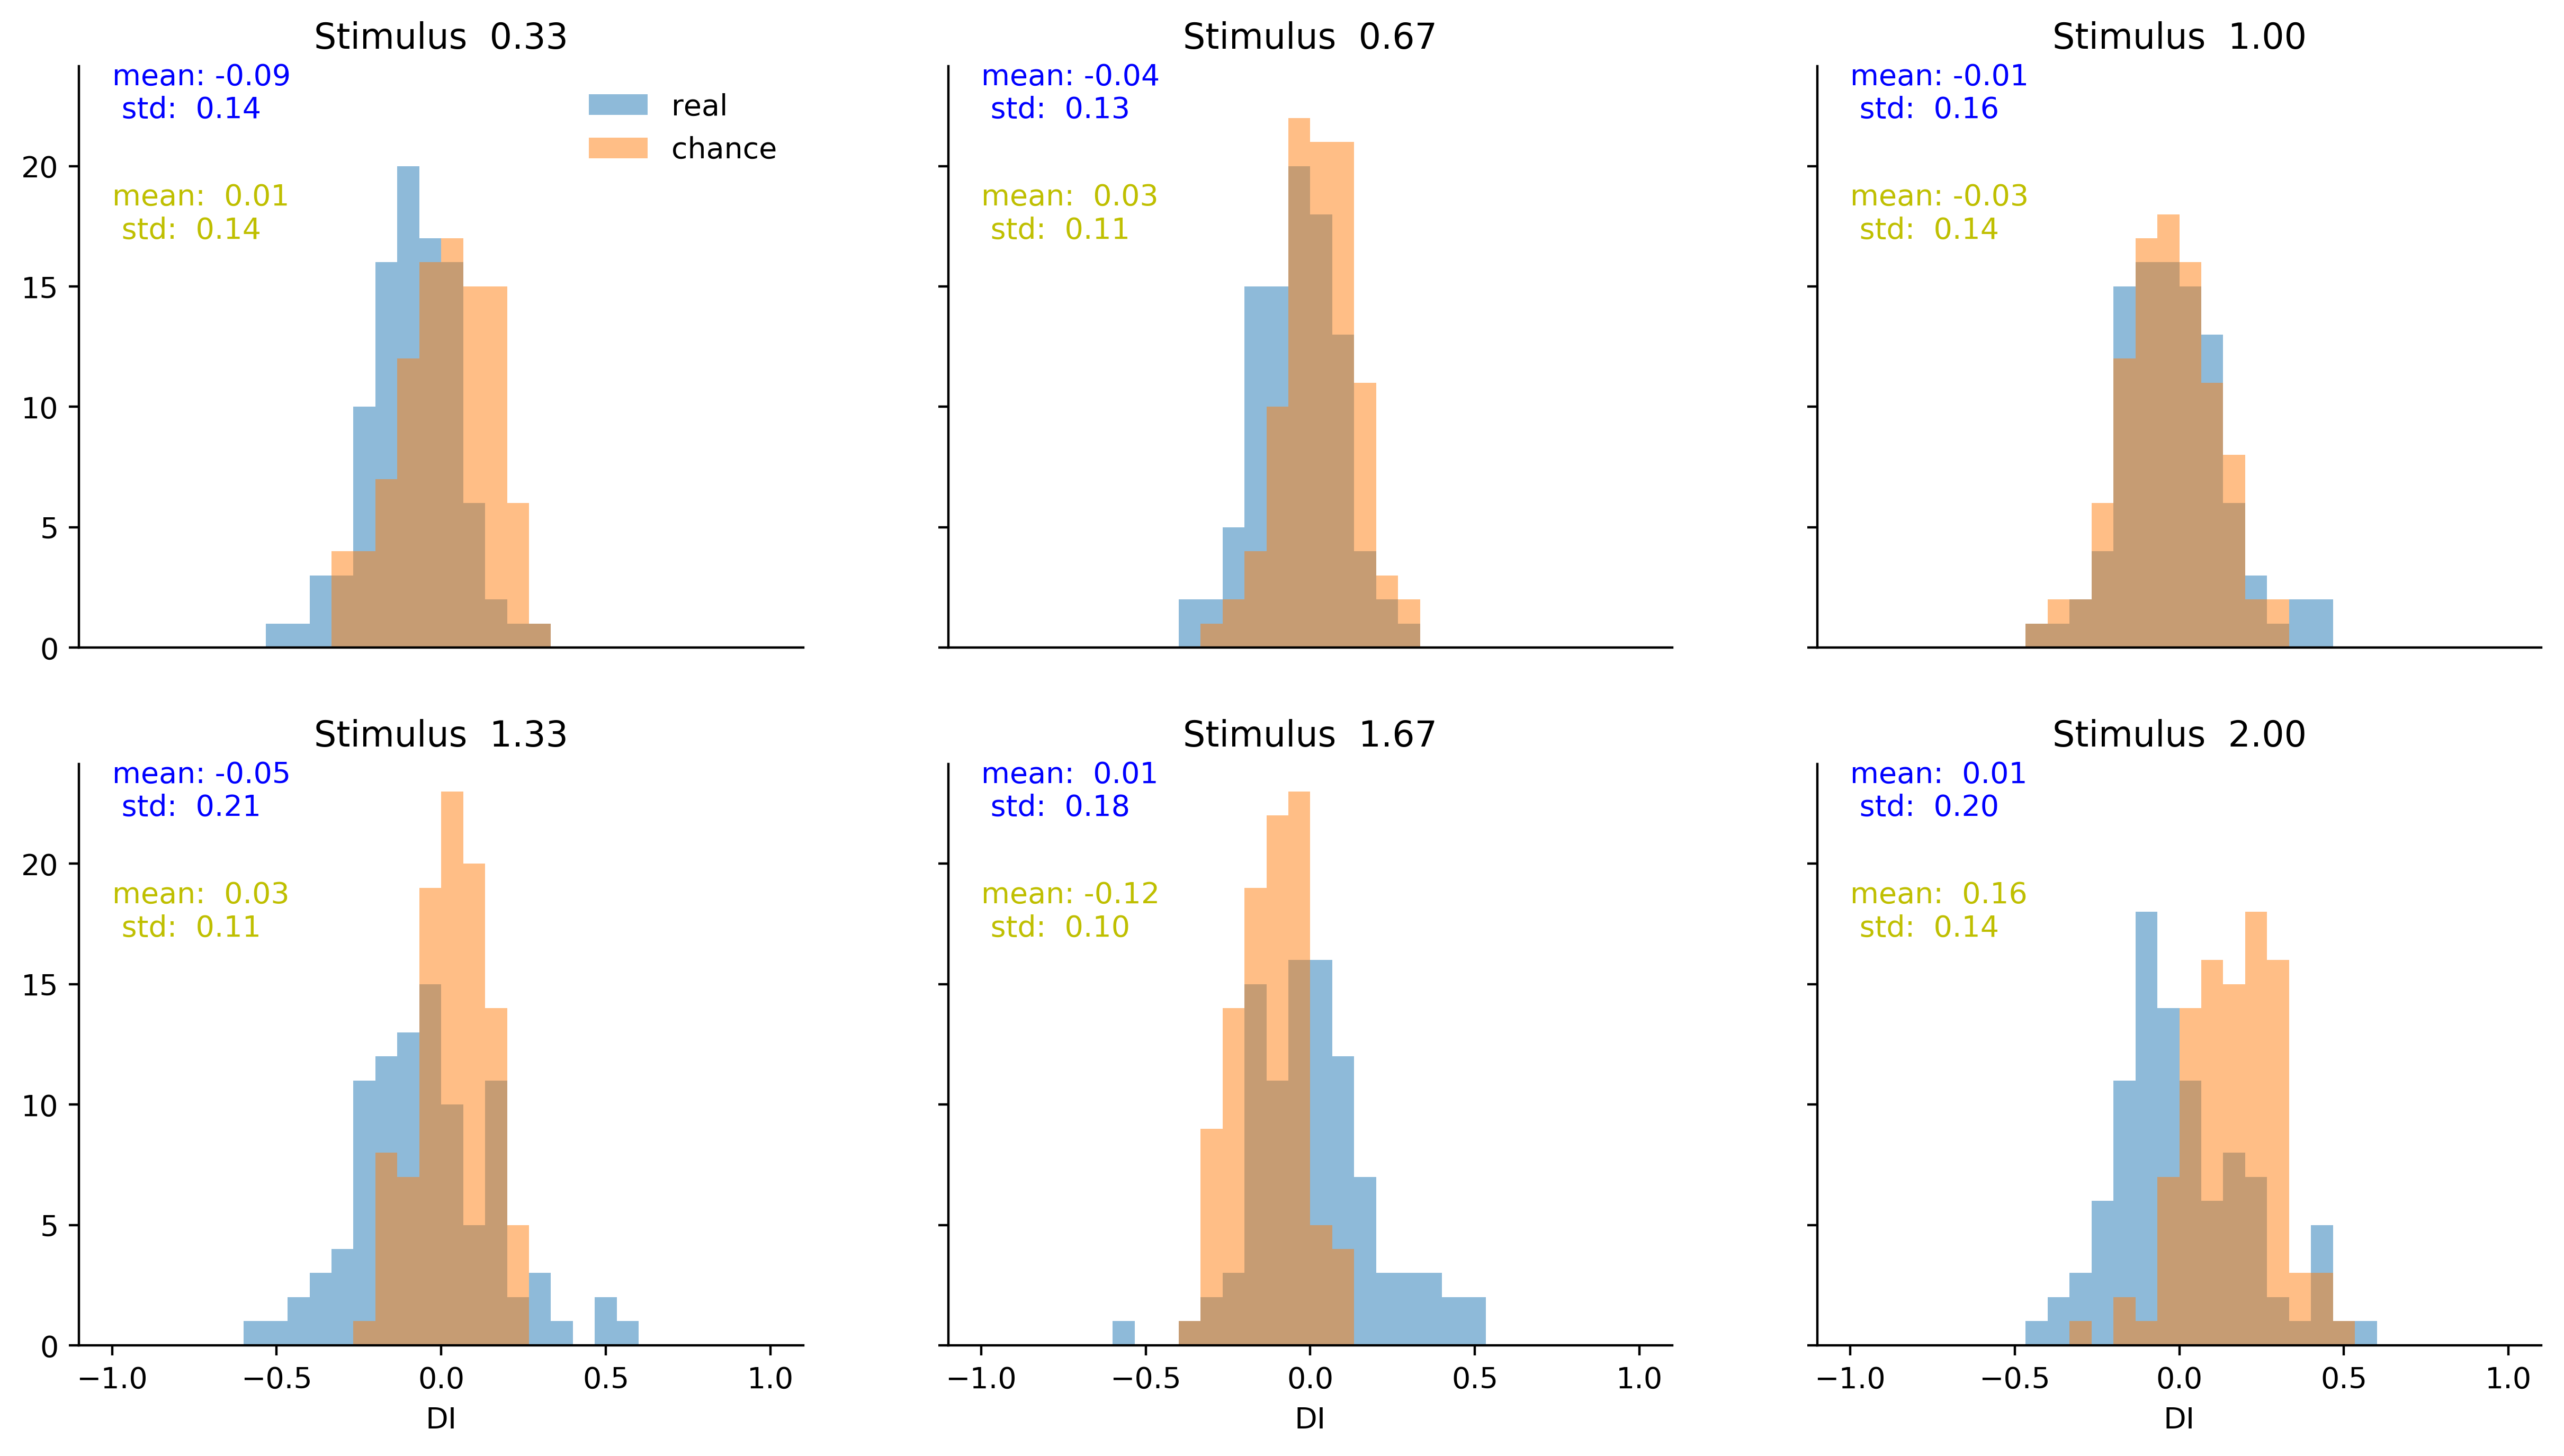

In [92]:
stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]        #exclude zero

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey=True, figsize=(15,8), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for k, amp in enumerate(stims):
    DIs = np.array(get_DIs(filename, amp))
    DIs_p = np.array(get_DIs(filename, amp, permute=True))
    print("for stimAmp = {0: .2f}: min DI: ".format(amp) ,"{0: .2f}".format(np.min(DIs)), ", max DI:", "{0: .2f}".format(np.max(DIs)))

    axes[k].hist(DIs, bins=30, range=(-1,1), label='real', alpha=0.5)
    axes[k].hist(DIs_p, bins=30, range=(-1,1), label='chance', alpha=0.5)
    axes[k].text(-1,22, 'mean: {0: .2f} \n std: {1: .2f}'.format(np.mean(DIs), np.std(DIs)), color='b', alpha=1)
    axes[k].text(-1,17, 'mean: {0: .2f} \n std: {1: .2f}'.format(np.mean(DIs_p), np.std(DIs_p)), color='y', alpha=1)
    
    axes[k].set_title('Stimulus {0: .2f}'.format(amp))
    
    axes[k].spines['top'].set_visible(False)
    axes[k].spines['right'].set_visible(False)
    axes[k].get_xaxis().tick_bottom()
    axes[k].get_yaxis().tick_left()
    if k == 0:
        axes[k].legend(frameon=False)
        
    if k in [0,1,2]:
        axes[k].xaxis.set_ticks_position('none')
    if k in [3,4,5]:
        axes[k].set_xlabel('DI')